## Introduction
### Create a machine learning model to predict whether an individual earns above 50,000 in a specific currency or not.

### Import the necessary packages.

In [227]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")
import re
#import klib

from scipy.stats import skew, kurtosis
from prettytable import PrettyTable
import matplotlib.ticker as mtick
from sklearn.impute import SimpleImputer

from sklearn.model_selection import  cross_val_score,KFold,train_test_split,ShuffleSplit,StratifiedKFold,learning_curve
from catboost import CatBoostClassifier,Pool,cv,monoforest
from sklearn.metrics import f1_score,classification_report,confusion_matrix,log_loss,ConfusionMatrixDisplay,roc_curve,precision_recall_curve
from sklearn.preprocessing import LabelEncoder,StandardScaler,PolynomialFeatures
import math
import shap
shap.initjs()

### Import train and test dataset

In [4]:
train=pd.read_csv("../input/zindi-income-prediction-challenge-by-umojahack/Train.csv")
test=pd.read_csv("../input/zindi-income-prediction-challenge-by-umojahack/Test.csv")
feat_info=pd.read_csv("../input/zindi-income-prediction-challenge-by-umojahack/VariableDefinitions.csv")

### Pre-Processing Function

In [2]:
def pre_process(df):
    
    # Drop columns which have more than 70% missing data
    df=df.drop(columns=['education_institute','unemployment_reason',
                     'is_labor_union','under_18_family','veterans_admin_questionnaire',
                     'old_residence_reg','old_residence_state'],axis=1)
    
    # Change categorical column values to lower case
    for col in df.select_dtypes(include='object').columns:
        df[col]=df[col].str.lower()
        
    # Change numerical column values to null that is less than 1   
    for col in ['age','wage_per_hour','gains', 'losses', 'stocks_status','importance_of_record']:
        df[col]=df[col].apply(lambda x: np.nan if x<1 else x)
    
    # Create an indicator if person's age less 18
    df['age_less_18']=(df['age']<18).astype('int')  
    
    
    # Replace special characters and NA to null in the following categorical columns    
    for col in ['country_of_birth_own','country_of_birth_father','country_of_birth_mother',
                'migration_code_change_in_msa','migration_prev_sunbelt','migration_code_move_within_reg',
                'migration_code_change_in_reg']:
        df[col]=df[col].replace("?|NA",np.nan)
    
    # Create an indicator for the columns that have missing rows
    for col in df.columns[df.isnull().any()]:
        df[f"{col}_isnull"]=df[col].isnull().astype('int')
    
    
    # Define median imputer
    imp_mean = SimpleImputer(strategy='median')
    
    # Define mode imputer
    imp_mode = SimpleImputer(strategy='most_frequent')
    
    # Impute mode values for the categorical missing columns
    for col in ['class','occupation_code_main', 'is_hispanic',
                'country_of_birth_own',
                'country_of_birth_father','country_of_birth_mother',
                'migration_code_change_in_msa','migration_prev_sunbelt',
                'migration_code_move_within_reg','migration_code_change_in_reg', 
                'residence_1_year_ago']:
        df[col]=imp_mode.fit_transform(df[[col]])
    
    # Impute mean values for the numerical missing columns
    for col in ['age','wage_per_hour','gains', 'losses', 'stocks_status','importance_of_record']:
        df[col]=imp_mean.fit_transform(df[[col]])
        
    
    # Replace the "ever" with "never" in the following categorical column values
    for col in ['household_stat','household_summary']:
        df[col]=df[col].str.replace("\sever\s",' never ')
    
    
    # Replace "sa and s" with " "
    df['household_stat']=df['household_stat'].str.replace("\sa\s"," ")
    
    # Replace "married" with marr
    df['household_stat']=df['household_stat'].str.replace("\smarried\s"," marr ")
    
    
    # Categorical columns list
    grpcol=[ 'gender', 'education', 'class', 
                   'marital_status', 'race', 'is_hispanic', 'employment_commitment',
                    'industry_code_main',
                   'occupation_code_main', 'household_stat', 'household_summary',
                   'tax_status',
                   'citizenship', 'country_of_birth_own', 'country_of_birth_father',
                   'country_of_birth_mother', 'migration_code_change_in_msa',
                   'migration_prev_sunbelt', 'migration_code_move_within_reg',
                   'migration_code_change_in_reg', 'residence_1_year_ago',
                   'employment_stat','working_week_per_year','industry_code','occupation_code',
                   'total_employed','vet_benefit','mig_year']
    
    for col in grpcol:
        df[f"{col}_count"]=df.groupby(col)[col].transform('count')
    
    # Target count by above categorical columns list
    df['income_cat_count']=df.groupby(grpcol)['income_above_limit'].transform('count')
        
    
    # Numerical columns list
    numcols= ['age','wage_per_hour','gains', 'losses', 'stocks_status','importance_of_record']
    
    
    # Groupby numerical summary
    def feature_eng(df):
        for valcol in numcols:
            df1=(df.groupby(grpcol)[valcol].
             agg({'min','median','mean','max'}).reset_index())
            df1=(df1.rename(columns={c:valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                match("(min|median|mean|max)")]}))
            df=pd.merge(df,df1,on=grpcol,how='left')
        return df  

    # Apply feature_eng function to data
    df=feature_eng(df)
    
    
    # Return the dataframe
    return df
    
   
    

### Let's combine the train and test data.

In [8]:
train['data']='train'
test['data']='test'
full_data=pd.concat([train,test],axis=0)

### Apply pre-processing function to full_data

In [9]:
full_data=pre_process(full_data)

### Split train and test data from full_data

In [24]:
train1=full_data[full_data['data']=='train']
test1=full_data[full_data['data']=='test']


### Let's encode the target column

In [25]:
target_map={'below limit':0,
           'above limit':1}
train1['income_above_limit']=train1['income_above_limit'].map(target_map)

### Let's split the predictor and response column.

In [28]:
for i,col  in enumerate(train1.columns.values):
    print(f"{i}_{col}")

0_ID
1_age
2_gender
3_education
4_class
5_marital_status
6_race
7_is_hispanic
8_employment_commitment
9_employment_stat
10_wage_per_hour
11_working_week_per_year
12_industry_code
13_industry_code_main
14_occupation_code
15_occupation_code_main
16_total_employed
17_household_stat
18_household_summary
19_vet_benefit
20_tax_status
21_gains
22_losses
23_stocks_status
24_citizenship
25_mig_year
26_country_of_birth_own
27_country_of_birth_father
28_country_of_birth_mother
29_migration_code_change_in_msa
30_migration_prev_sunbelt
31_migration_code_move_within_reg
32_migration_code_change_in_reg
33_residence_1_year_ago
34_importance_of_record
35_income_above_limit
36_data
37_age_less_18
38_age_isnull
39_class_isnull
40_wage_per_hour_isnull
41_occupation_code_main_isnull
42_gains_isnull
43_losses_isnull
44_stocks_status_isnull
45_migration_code_change_in_msa_isnull
46_migration_prev_sunbelt_isnull
47_migration_code_move_within_reg_isnull
48_migration_code_change_in_reg_isnull
49_residence_1_yea

In [161]:
X=train1.iloc[:,np.r_[1:35,37:50,51:104]]
y=train1['income_above_limit']

### Split data into train and validation data

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True)

### Train catboost model

In [163]:
cat_clf = CatBoostClassifier(eval_metric="F1",task_type='CPU',   grow_policy = 'Lossguide')
                         
                              
cat_clf.fit(X_train,y_train,early_stopping_rounds=50,eval_set=(X_test, y_test),
              
              cat_features=X.select_dtypes(include='object').columns.values
                        )

Learning rate set to 0.11228
0:	learn: 0.4391144	test: 0.4048387	best: 0.4048387 (0)	total: 400ms	remaining: 6m 39s
1:	learn: 0.4341430	test: 0.4067889	best: 0.4067889 (1)	total: 748ms	remaining: 6m 13s
2:	learn: 0.4080403	test: 0.3790071	best: 0.4067889 (1)	total: 1.07s	remaining: 5m 55s
3:	learn: 0.4273764	test: 0.3927968	best: 0.4067889 (1)	total: 1.5s	remaining: 6m 12s
4:	learn: 0.4059051	test: 0.3802899	best: 0.4067889 (1)	total: 1.9s	remaining: 6m 17s
5:	learn: 0.4097645	test: 0.3906250	best: 0.4067889 (1)	total: 2.3s	remaining: 6m 21s
6:	learn: 0.4104596	test: 0.3909381	best: 0.4067889 (1)	total: 2.87s	remaining: 6m 46s
7:	learn: 0.4288245	test: 0.4052889	best: 0.4067889 (1)	total: 3.25s	remaining: 6m 43s
8:	learn: 0.4200129	test: 0.3968714	best: 0.4067889 (1)	total: 3.67s	remaining: 6m 44s
9:	learn: 0.4320454	test: 0.4042676	best: 0.4067889 (1)	total: 3.97s	remaining: 6m 33s
10:	learn: 0.4411971	test: 0.4151697	best: 0.4151697 (10)	total: 4.35s	remaining: 6m 31s
11:	learn: 0.44

### Shap model explaination

In [174]:
explainer = shap.TreeExplainer(cat_clf)
shap_values = explainer.shap_values(Pool(X,y,cat_features=X.select_dtypes(include='object').columns.values))

### Feature importance plot

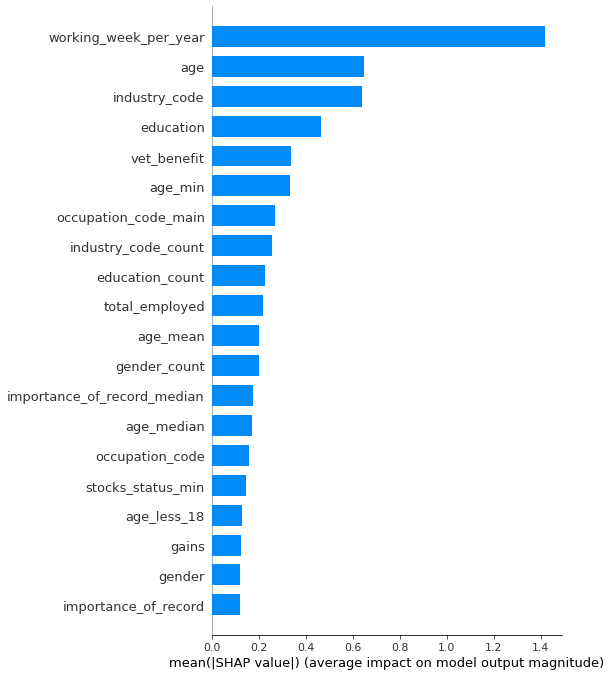

In [176]:
shap.summary_plot(shap_values, X, plot_type="bar",
                  max_display=20)

### Top features impact the model

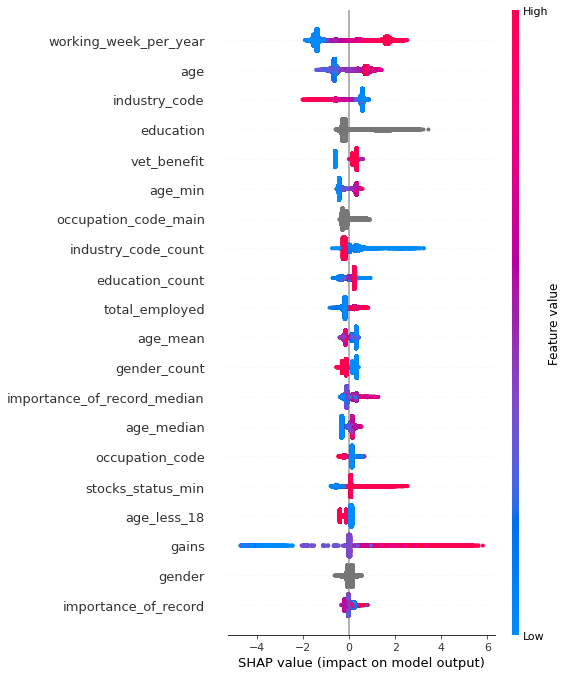

In [177]:
shap.summary_plot(shap_values, X)

### Let's see which feature influences the model prediction for a single observation in each class.

### For class:0

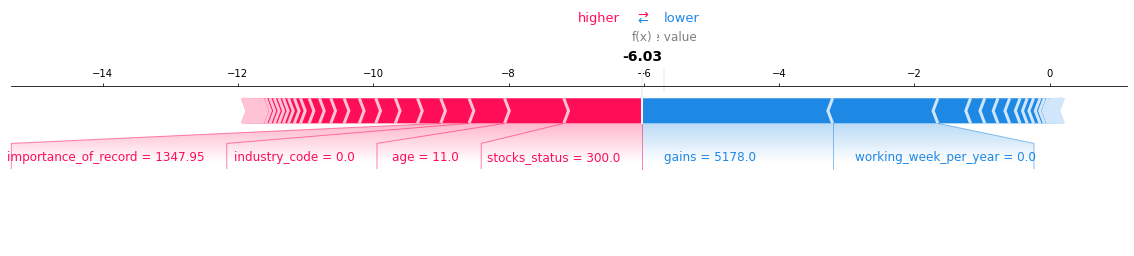

In [180]:
shap.force_plot(explainer.expected_value, shap_values[107155,:], X_train.iloc[107155,:],matplotlib=True)

### For class:1

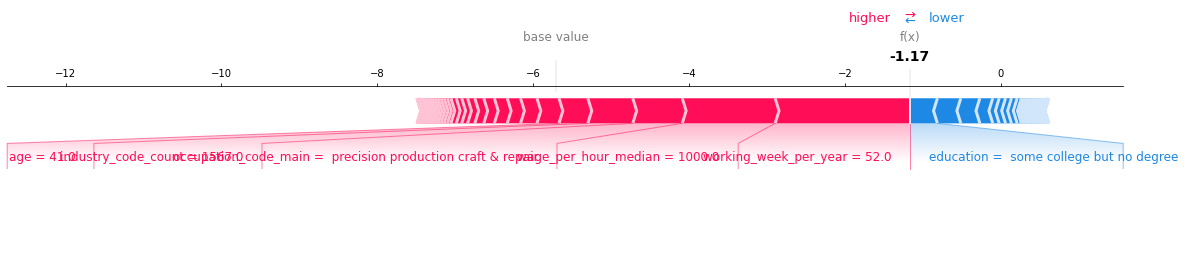

In [183]:
shap.force_plot(explainer.expected_value, shap_values[4735,:], X.iloc[4735,:],matplotlib=True,)

### Predict validation data

In [171]:
val_pred=cat_clf.predict_proba(X_test)[:,1]

### Default threshold was not giving the good results.So i have tried threshold tuning method and it gave me th good result.

### Function  to get optimal threshold 

In [116]:
def optimal_threshold(y_true,y_prediction,types=''):
    if types == 'gmean':
        fpr, tpr, thresholds = roc_curve(y_true, y_prediction)
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # plot the roc curve for the model
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Logistic')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
        #axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"Best Threshold={thresholds[ix]:.{5} f}, G-Mean={gmeans[ix]:.{3}f}")
        print(f"Best Threshold={thresholds[ix]:.{5} f}, G-Mean={gmeans[ix]:.{3}f}")
        plt.legend()
        # show the plot
        plt.show()
    elif types == "pr_re":
        precision, recall, thresholds = precision_recall_curve(y_true, y_prediction)
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        no_skill = len(y_true[y_true==1]) / len(y_true)
        plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
        plt.plot(recall, precision, marker='.', label='Logistic')
        plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f"Best Threshold={thresholds[ix]:.{10}f}, F-Score={fscore[ix]:.{3}f}")
        print(f"Best Threshold={thresholds[ix]:.{10}f}, F-Score={fscore[ix]:.{3}f}")
        plt.legend()
        # show the plot
        plt.show()
    elif types == 'tune':
        def to_class_label(probs, threshold):
            """convert predicted probabilities to class labels"""
            return (probs >= threshold).astype('int')

        def get_optimal_threshold(y_true, y_prediction):
            """Threshold tuning"""
            thresholds = np.arange(0, 1, 0.0001)
            #y_hat = fitted_model.predict_proba(x_test)
            #pos_clas_probs = y_hat[:, 1]
            f1_scores = [f1_score(y_true, to_class_label(y_prediction, thres),average='weighted') for thres in thresholds]
            idx = np.argmax(f1_scores)
            return idx,f1_scores,thresholds[idx]
        
        score,list_score,opt_thres = get_optimal_threshold(y_true, y_prediction)
        print(f'Optimal threshold {opt_thres:.4f}')
        plt.plot(np.arange(0, 1, 0.0001), list_score,'k')
        plt.scatter(np.arange(0, 1, 0.0001)[score], list_score[score], marker='o', color='green', label='Best')
        plt.legend()
        plt.show()
        #plt.plot(np.arange(0, 1, 0.0005), , marker='.', label='Logistic')
        #plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        
    

Optimal threshold 0.3862


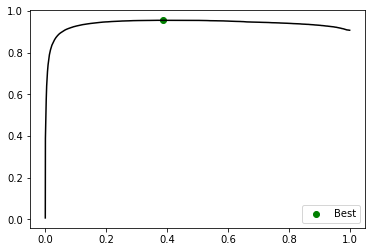

In [172]:
optimal_threshold(y_test,val_pred,types="tune")

### Confustion matrix for train and validation data

In [217]:
val_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_test,[1 if i>0.3862 else 0 for i in val_pred]),display_labels=['Below limit', 'Above limit'])

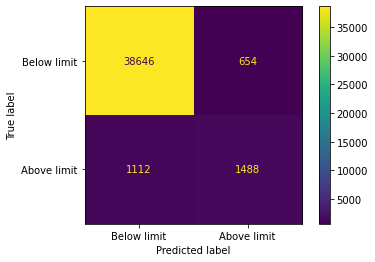

In [218]:
val_confusion_matrix.plot();

In [224]:
print(classification_report(y_test,[1 if i>0.3862 else 0 for i in val_pred],target_names=['Below limit', 'Above limit']))

              precision    recall  f1-score   support

 Below limit       0.97      0.98      0.98     39300
 Above limit       0.69      0.57      0.63      2600

    accuracy                           0.96     41900
   macro avg       0.83      0.78      0.80     41900
weighted avg       0.95      0.96      0.96     41900



In [219]:
train_pred=cat_clf.predict_proba(X_train)[:,1]
train_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_train,[1 if i>0.3862 else 0 for i in train_pred]),display_labels=['Below limit', 'Above limit'])

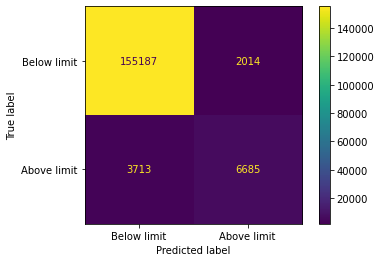

In [220]:
train_confusion_matrix.plot();

In [223]:
print(classification_report(y_train,[1 if i>0.3862 else 0 for i in train_pred],target_names=['Below limit', 'Above limit']))

              precision    recall  f1-score   support

 Below limit       0.98      0.99      0.98    157201
 Above limit       0.77      0.64      0.70     10398

    accuracy                           0.97    167599
   macro avg       0.87      0.82      0.84    167599
weighted avg       0.96      0.97      0.96    167599



### Predict New data

In [198]:
test_pred=cat_clf.predict_proba(test1.loc[:,X.columns.values])[:,1]

### Apply the optimal threshold value for the predicted probability values.

In [199]:
test_pred_p=[1 if i>0.3862 else 0 for i in test_pred]

### Create result dataframe

In [200]:
res=pd.DataFrame({'ID':test['ID'],'income_above_limit':test_pred_p})

In [201]:
res.head()

,ID,income_above_limit
0,ID_TZ209499,0
1,ID_TZ209500,0
2,ID_TZ209501,1
3,ID_TZ209502,0
4,ID_TZ209503,0


In [202]:
res['income_above_limit'].value_counts()

0    85183
1     4603
Name: income_above_limit, dtype: int64

In [149]:
res.to_csv("submission.csv",index=False)